# Description
- This project aims to accurately classify pictures of dogs and cats by building a convolutional Nueral Network(CNN).
- The data is preprocessed using a VGG16 pretrained base model
- The CNN is created by using a sequential model
- We will use links below to follow along:
    - Image Preparation for Convolutional Neural Networks with TensorFlow's Keras API https://www.youtube.com/watch?v=_L2uYfVV48I
    - Build and Train a Convolutional Neural Network with TensorFlow's Keras API https://www.youtube.com/watch?v=3V9YFPfgyAY
    - Convolutional Neural Network Predictions with TensorFlow's Keras API https://www.youtube.com/watch?v=e47ISlpYFok
    

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.models import load_model

# Import Data

In [12]:
path = '/Volumes/Datasets/PetImages'
os.chdir(path)

In [13]:
# Verify the current directory
print("Current directory:", os.getcwd())


Current directory: /Volumes/Datasets/PetImages


In [14]:
# List files in the current directory
files = os.listdir()
print("Files in shared folder:", files)

Files in shared folder: ['Cat', '.DS_Store', 'Dog', 'train', 'valid', 'test', 'logs']


# Data Preparation

### Seperate the data into train, validation, and test
NOTE: Only needs to run once successfully!

In [7]:
#Create train, validation, and test set folders
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')
    #Moves a small sample of the current sample data to the needed folders
    #If the sample data was labeled by file name instead of folders, syntax would be Cat* instead of Cat/*
    for c in random.sample(glob.glob(path+'/Cat/*'),2000):
        shutil.copy(c, 'train/cat')
    for c in random.sample(glob.glob(path+'/Dog/*'),2000):
        shutil.copy(c, 'train/dog')
    for c in random.sample(glob.glob(path+'/Cat/*'),500):
        shutil.copy(c, 'valid/cat')
    for c in random.sample(glob.glob(path+'/Dog/*'),500):
        shutil.copy(c, 'valid/dog')
    for c in random.sample(glob.glob(path+'/Cat/*'),200):
        shutil.copy(c, 'test/cat')
    for c in random.sample(glob.glob(path+'/Dog/*'),200):
        shutil.copy(c, 'test/dog')
    

### Transform the Data using VGG16 model

In [15]:
# Paths to train/valid/test directories
train_path = '/Volumes/Datasets/PetImages/train'
valid_path = '/Volumes/Datasets/PetImages/valid'
test_path = '/Volumes/Datasets/PetImages/test'

In [16]:
# Transform the data to a keras generator
#Preprocess the ImageDataGenerator the way that the vgg16 model is preprocessed
#Resize the images to a standard size
train_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory = train_path, target_size=(224,224), classes =['cat','dog'], batch_size = 10)
valid_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory = valid_path, target_size=(224,224), classes =['cat','dog'], batch_size = 10)
    #Set shuffle equal to falrse
test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory = test_path, target_size=(224,224), classes =['cat','dog'], batch_size = 10,\
                        shuffle=False)


Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


### Verify batches

In [18]:
#Verifying that the batches are indeed correct
assert train_batches.n == 4000
assert valid_batches.n == 1000
assert test_batches.n == 400
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

### Show a batch sample and it's labels

In [19]:
#Grab one batch
imgs, labels = next(train_batches)

In [20]:
#This function will plot images in the form of a frid with 1 row and 10 cloumns/images
def plotImages(images_arr):
    fig,axes = plt.subplots(1,10,figsize = (20,20))
    axes  = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

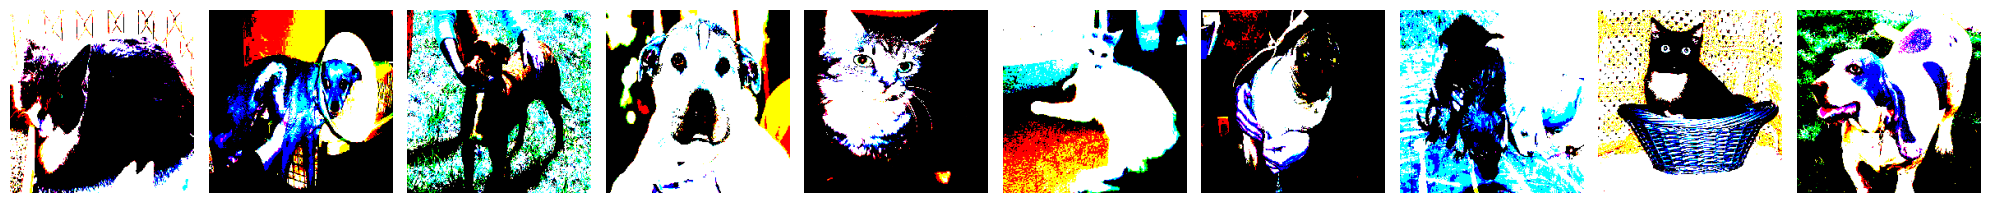

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [21]:
#call the plotImages function to show the imgs from the first batch
plotImages(imgs)
print(labels)

# Build and train a CNN

In [22]:
#Conv2D accepts image data, padding 'same' to specify our images will have zero padding
#Maxpooling cuts image dimensions in half specified by "strides"
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size = (3,3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax'),
])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │       401,410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 420,802 (1.61 MB)

 Trainable params: 420,802 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
hist = model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/anaconda3/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


400/400 - 158s - 394ms/step - accuracy: 0.6072 - loss: 4.7720 - val_accuracy: 0.6970 - val_loss: 0.7678
Epoch 2/10
400/400 - 142s - 354ms/step - accuracy: 0.8665 - loss: 0.3468 - val_accuracy: 0.7140 - val_loss: 0.7595
Epoch 3/10
400/400 - 127s - 318ms/step - accuracy: 0.9830 - loss: 0.0703 - val_accuracy: 0.7360 - val_loss: 0.7264
Epoch 4/10
400/400 - 131s - 327ms/step - accuracy: 0.9992 - loss: 0.0185 - val_accuracy: 0.7480 - val_loss: 0.7590
Epoch 5/10
400/400 - 186s - 464ms/step - accuracy: 0.9995 - loss: 0.0070 - val_accuracy: 0.7550 - val_loss: 0.7761
Epoch 6/10
400/400 - 245s - 613ms/step - accuracy: 0.9998 - loss: 0.0037 - val_accuracy: 0.7440 - val_loss: 0.8331
Epoch 7/10
400/400 - 248s - 620ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.7460 - val_loss: 0.8531
Epoch 8/10
400/400 - 302s - 756ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.7370 - val_loss: 0.8911
Epoch 9/10
400/400 - 161s - 402ms/step - accuracy: 1.0000 - loss: 7.7506e-04 - val_accuracy

# Save the model

In [35]:
#save model, the 'models' parameter creates a folder named models
code_path = '/Volumes/Datasets/PetImages/models'
model.save(os.path.join(code_path,'catdogmodelV1.keras'))

# Load the model

In [39]:
new_model = load_model(os.path.join(code_path,'catdogmodelV1.keras'))

In [40]:
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │       401,410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,262,408 (4.82 MB)

 Trainable params: 420,802 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 841,606 (3.21 MB)

# Predict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

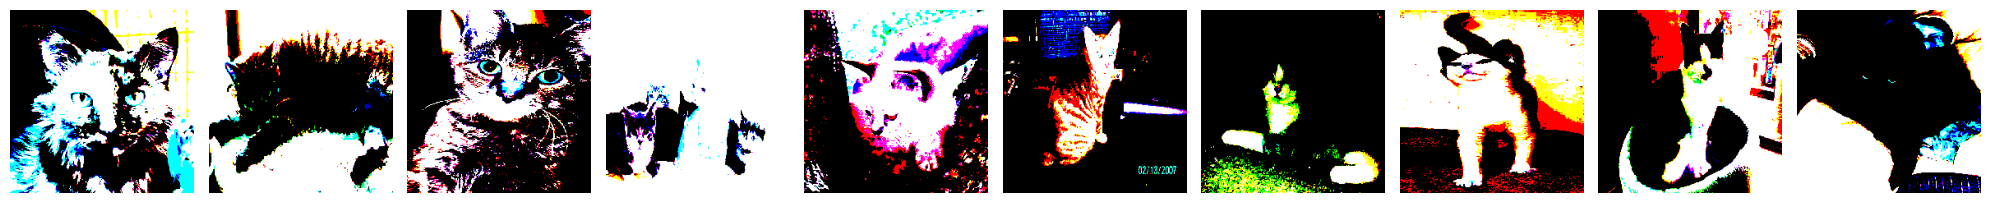

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [26]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
#Should be all 1's because we didnt shuffle the test dataset
print(test_labels)

In [27]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [28]:
predictions = model.predict(x=test_batches, verbose=0)

In [29]:
np.round(predictions)

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

### Confusion Matrix

In [30]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=1))

In [31]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    '''This function prints and plots the confursion matrix.
    Normalization can be applied by setting "normalize=True".'''
    
    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i,j], horizontalalignment ='center', color='white' if cm[i,j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [32]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[145  55]
 [ 55 145]]


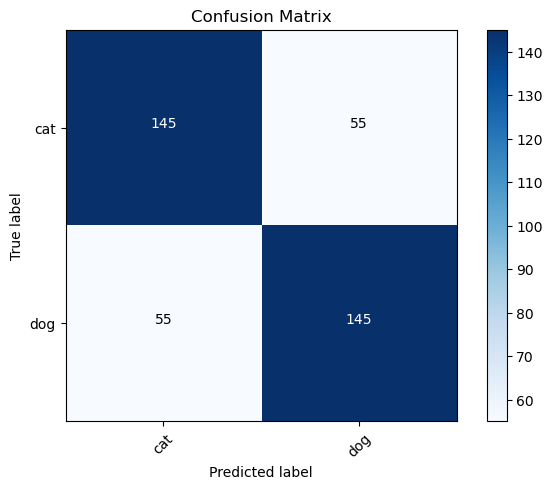

In [33]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title = 'Confusion Matrix')

### Performance

In [29]:
pre = Precision()
re = Recall()
acc= BinaryAccuracy()

In [ ]:
print(f'precision: {pre.result()} Recall: {re.result()} Accuracy: {acc.result()}')